1. Data Preprocessing
 * Read the datasets.
 * Convert appropriate columns to integers or dates
 * Store the data in structured Pandas DataFrames.
2. Basic Data Exploration and Summary Statistics
 * Present three conclusions with different statistical methods (e.g., correlation analysis, hypothesis testing, and summary statistics).
 * Include one plot for each method.

# Importing Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# 1) Data Preprocessing
## Importing our data

In [6]:
nba_players = pd.read_csv('all_seasons.csv')
team_stats = pd.read_csv('nba_team_stats_00_to_23.csv')
team_pg_stats = pd.read_csv('nba_team_stats_playoffs_00_to_21.csv')

## Parsing and Clenaing Data

#### Convert metrics

In [7]:
# covert height from cm to ft
nba_players['player_height_ft'] = round(nba_players['player_height'] / 2.54 / 12, 2)
# covert weight from kg to lb
nba_players['player_weight_lb'] = round(nba_players['player_weight'] * 2.204622622, 0)
# convert weight to int
nba_players['player_weight_lb'] = nba_players['player_weight_lb'].astype(int)

#### Check for missing values

In [8]:
# Check for missing values
print("\nMissing Values in NBA Players Data:")
print(nba_players.isnull().sum())
print("\nMissing Values in NBA Team Stats Data:")
print(team_stats.isnull().sum())
print("\nMissing Values in NBA Team Playoff Stats Data:")
print(team_pg_stats.isnull().sum())


Missing Values in NBA Players Data:
Unnamed: 0              0
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
player_height_ft        0
player_weight_lb        0
dtype: int64

Missing Values in NBA Team Stats Data:
teamstatspk                 0
Team                        0
games_played                0
wins                        0
losses                      0
win_percentage              0
Min                         0
points                      0
field_goals_made            0
field_goals_atte

> Only the college column has missing values. This is because pandas intepreted most as NaN instead of 'None'. We will replace these missing values with 'No College'. However, we will first do a hot deck imputation to see if we can fill in the missing values with the same player's college in a different season (some have None in some season and not in other season e.g "Jay Scrubb").

> Besdies there are 5 rows with no college mentioned only (empty space). But this can easily be fixed by hot deck imputation where we replace with values found in different seasons (same player).


#### Correcting features

In [9]:
# convert age from float to int
nba_players['age'] = nba_players['age'].astype(int)

# We'll convert draft_year from a str to a year by replacing undrafted w/ NaT
nba_players.loc[nba_players['draft_year'] == 'Undrafted', 'draft_year'] = pd.NaT
nba_players['draft_year'] = nba_players['draft_year'].apply(lambda x: pd.to_datetime(x, format='%Y'))

# We'll convert draft_round and draft_number from a str to a int by replacing undrafted w/ 0
nba_players['draft_round'] = nba_players['draft_round'].replace('Undrafted', 0)
nba_players['draft_round'] = nba_players['draft_round'].astype(int)
nba_players['draft_number'] = nba_players['draft_number'].replace('Undrafted', 0)
nba_players['draft_number'] = nba_players['draft_number'].astype(int)

# Column 'Unamed: 0' can be dropped as it is just an index and other redundant columns
nba_players = nba_players.drop(columns=['Unnamed: 0'])
team_stats = team_stats.drop(['teamstatspk'], axis=1)
team_pg_stats = team_pg_stats.drop(['teamstatspk'], axis=1)


#### Dealing with missing values

In [10]:
# example before fixing missing values
print("\nExample of Missing College:")
nba_players[nba_players['player_name'] == 'Jay Scrubb']


Example of Missing College:


,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
11234,Jay Scrubb,LAC,20,195.58,99.79024,,USA,2020-01-01,2,55,...,0.3,-2.8,0.022,0.14,0.217,0.458,0.015,2020-21,6.42,220
11834,Jay Scrubb,LAC,21,195.58,99.79024,NaN,USA,2020-01-01,2,55,...,0.4,6.9,0.016,0.10,0.188,0.486,0.095,2021-22,6.42,220
12798,Jay Scrubb,ORL,22,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.5,-28.5,0.000,0.30,0.151,0.825,0.056,2022-23,6.42,220


In [24]:


players_with_na_college = nba_players[nba_players['college'].isna()]

# EXPENSIVE OPERATION WARNING!
for index, row in players_with_na_college.iterrows():
  player_name = row['player_name']
  college = row['college']

  # if college is valid skip
  if college == college:
    continue

  # Find other occurrences of the same player where 'college' is valid
  valid_college = nba_players.loc[
      (nba_players['player_name'] == player_name) & 
      (nba_players['college'].notna()) & 
      (nba_players['college'].str.strip() != ''),
      'college'
  ]
  
  # If a valid college is found, update all occurrences of the player with the valid college
  if not valid_college.empty:
      nba_players.loc[nba_players['player_name'] == player_name, 'college'] = valid_college.iloc[0]

# now we replace remaining missing values with 'No College'
nba_players['college'] = nba_players['college'].fillna('No College')

print("\nExample After Fixing Missing College:")
nba_players[nba_players['player_name'] == 'Jay Scrubb']



Example After Fixing Missing College:


,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
11234,Jay Scrubb,LAC,20,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.3,-2.8,0.022,0.14,0.217,0.458,0.015,2020-21,6.42,220
11834,Jay Scrubb,LAC,21,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.4,6.9,0.016,0.10,0.188,0.486,0.095,2021-22,6.42,220
12798,Jay Scrubb,ORL,22,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.5,-28.5,0.000,0.30,0.151,0.825,0.056,2022-23,6.42,220


#### check for duplicates

In [25]:
# check for duplicates
print("\nNumber of Duplicates in NBA Players Data:")
print(nba_players.duplicated().sum())
print("\nNumber of Duplicates in NBA Team Stats Data:")
print(team_stats.duplicated().sum())
print("\nNumber of Duplicates in NBA Team Playoff Stats Data:")
print(team_pg_stats.duplicated().sum())

# More in-depth (looking at set of columns that should be a primary key)
print("nba_players duplicates: " + str(len(nba_players[['player_name', 'team_abbreviation', 'season']].drop_duplicates()) != len(nba_players)))
print("team_stats duplicates: " + str(len(team_stats[['Team', 'season']].drop_duplicates()) != len(team_stats)))
print("team_pg_stats duplicates: " + str(len(team_pg_stats[['team', 'season']].drop_duplicates()) != len(team_pg_stats)))

# now our player data is clean
print(nba_players.isnull().sum())


Number of Duplicates in NBA Players Data:
0

Number of Duplicates in NBA Team Stats Data:
0

Number of Duplicates in NBA Team Playoff Stats Data:
0
nba_players duplicates: False
team_stats duplicates: False
team_pg_stats duplicates: False
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college                 0
country                 0
draft_year           2358
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
player_height_ft        0
player_weight_lb        0
dtype: int64


> Ignore draft_year null values we converted "Undrafted" to NaT

In [26]:
nba_players.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996-01-01,2,42,...,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,6.33,209
1,Gaylon Nickerson,WAS,28,190.50,86.182480,Northwestern Oklahoma,USA,1994-01-01,2,34,...,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97,6.25,190
2,George Lynch,VAN,26,203.20,103.418976,North Carolina,USA,1993-01-01,1,12,...,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,6.67,228
3,George McCloud,LAL,30,203.20,102.058200,Florida State,USA,1989-01-01,1,7,...,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,6.67,225
4,George Zidek,DEN,23,213.36,119.748288,UCLA,USA,1995-01-01,1,22,...,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97,7.00,264


### Organizing Data

#### Merge Player Data with Team Stats

In [27]:
# Merge datasets on 'season' column
nba_combined = pd.merge(nba_players, team_stats, how='left', on='season', suffixes=('_player', '_team'))

print("\nCombined Data:")
print(nba_combined.head())


Combined Data:
        player_name team_abbreviation  age  player_height  player_weight  \
0  Randy Livingston               HOU   22         193.04      94.800728   
1  Gaylon Nickerson               WAS   28         190.50      86.182480   
2      George Lynch               VAN   26         203.20     103.418976   
3    George McCloud               LAL   30         203.20     102.058200   
4      George Zidek               DEN   23         213.36     119.748288   

                 college country draft_year  draft_round  draft_number  ...  \
0        Louisiana State     USA 1996-01-01            2            42  ...   
1  Northwestern Oklahoma     USA 1994-01-01            2            34  ...   
2         North Carolina     USA 1993-01-01            1            12  ...   
3          Florida State     USA 1989-01-01            1             7  ...   
4                   UCLA     USA 1995-01-01            1            22  ...   

   defensive_rebounds  rebounds  assists  turnovers 

# Data Exploration

### Examining nba_players (NBA Players Stats (1996-2022))

In [28]:
print("Columns: ")
print(nba_players.columns, "\n\n")

print("Column Types:")
print(nba_players.dtypes, "\n\n")

for column in nba_players.columns:
  print(nba_players[column].describe())
# Somethings to note:
# player_height is in cm, player_weight is in kg
# pts, reb, ast are averaged

# Somethings to note about the data:
# 'draft_year', 'draft_round', and 'draft_number' are type string b/c of value 'undrafted', can substitute undraft w/ missing placeholder (such as -1 for ints, 0000 for year)
# Column 'Unamed: 0' can be dropped as it is just an index
# age could be converted to type int
nba_players

Columns: 
Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season',
       'player_height_ft', 'player_weight_lb'],
      dtype='object') 


Column Types:
player_name                  object
team_abbreviation            object
age                           int64
player_height               float64
player_weight               float64
college                      object
country                      object
draft_year           datetime64[ns]
draft_round                   int64
draft_number                  int64
gp                            int64
pts                         float64
reb                         float64
ast                         float64
net_rating                  float64
oreb_pct                    float64
dreb_pct                    float64
usg_pct     

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996-01-01,2,42,...,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,6.33,209
1,Gaylon Nickerson,WAS,28,190.50,86.182480,Northwestern Oklahoma,USA,1994-01-01,2,34,...,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97,6.25,190
2,George Lynch,VAN,26,203.20,103.418976,North Carolina,USA,1993-01-01,1,12,...,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,6.67,228
3,George McCloud,LAL,30,203.20,102.058200,Florida State,USA,1989-01-01,1,7,...,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,6.67,225
4,George Zidek,DEN,23,213.36,119.748288,UCLA,USA,1995-01-01,1,22,...,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97,7.00,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Joel Embiid,PHI,29,213.36,127.005760,Kansas,Cameroon,2014-01-01,1,3,...,4.2,8.8,0.057,0.243,0.370,0.655,0.233,2022-23,7.00,280
12840,John Butler Jr.,POR,20,213.36,86.182480,Florida State,USA,NaT,0,0,...,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,2022-23,7.00,190
12841,John Collins,ATL,25,205.74,102.511792,Wake Forest,USA,2017-01-01,1,19,...,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022-23,6.75,226
12842,Jericho Sims,NYK,24,208.28,113.398000,Texas,USA,2021-01-01,2,58,...,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022-23,6.83,250


### Examining team_stats (Regular Season Stats 2000-2023)

In [29]:
print("Columns: ")
print(team_stats.columns, "\n")

print("Column Types:")
print(team_stats.dtypes)

team_stats

Columns: 
Index(['Team', 'games_played', 'wins', 'losses', 'win_percentage', 'Min',
       'points', 'field_goals_made', 'field_goals_attempted',
       'field_goal_percentage', 'three_pointers_made',
       'three_pointers_attempted', 'three_point_percentage',
       'free_throws_made', 'free_throw_attempted', 'free_throw_percentage',
       'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists',
       'turnovers', 'steals', 'blocks', 'blocks_attempted', 'personal_fouls',
       'personal_fouls_drawn', 'plus_minus', 'season'],
      dtype='object') 

Column Types:
Team                         object
games_played                  int64
wins                          int64
losses                        int64
win_percentage              float64
Min                           int64
points                        int64
field_goals_made              int64
field_goals_attempted         int64
field_goal_percentage       float64
three_pointers_made           int64
three_pointers_attem

,Team,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,field_goal_percentage,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,Boston Celtics,82,64,18,0.780,3966,9887,3601,7396,48.7,...,3799,2207,979,557,538,304,1326,1416,930,2023-24
1,Denver Nuggets,82,57,25,0.695,3941,9418,3610,7279,49.6,...,3643,2415,1036,585,456,394,1489,1467,431,2023-24
2,Oklahoma City Thunder,82,57,25,0.695,3961,9847,3653,7324,49.9,...,3447,2223,1039,694,538,419,1545,1548,608,2023-24
3,Minnesota Timberwolves,82,56,26,0.683,3961,9264,3383,6974,48.5,...,3577,2184,1162,647,497,371,1544,1630,529,2023-24
4,LA Clippers,82,51,31,0.622,3941,9481,3473,7108,48.9,...,3523,2097,1078,640,413,384,1519,1537,269,2023-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,Atlanta Hawks,82,25,57,0.305,3946,7459,2876,6668,43.1,...,3518,1559,1368,634,387,513,1863,7,-427,2000-01
712,Vancouver Grizzlies,82,23,59,0.280,3956,7522,2870,6539,43.9,...,3325,1899,1291,586,359,476,1733,5,-470,2000-01
713,Washington Wizards,82,19,63,0.232,3936,7645,2833,6453,43.9,...,3386,1647,1391,630,383,511,1913,9,-547,2000-01
714,Golden State Warriors,82,17,65,0.207,3956,7584,2937,7175,40.9,...,3730,1788,1301,742,410,493,1727,6,-742,2000-01


### Examining team_pg_stats (Playoff Games Stats 2000-2021)

In [30]:
print("Columns: ")
print(team_pg_stats.columns, "\n")

print("Column Types:")
print(team_pg_stats.dtypes)

team_pg_stats

Columns: 
Index(['team', 'games_played', 'wins', 'losses', 'win_percentage', 'minutes',
       'points', 'field_goals_made', 'field_goals_attempted',
       'field_goal_percentage', 'three_pointers_made',
       'three_pointers_attempted', 'three_point_percentage',
       'free_throws_made', 'free_throw_attempted', 'free_throw_percentage',
       'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists',
       'turnovers', 'steals', 'blocks', 'blocks_attempted', 'personal_fouls',
       'personal_fouls_drawn', 'plus_minus', 'season'],
      dtype='object') 

Column Types:
team                         object
games_played                  int64
wins                          int64
losses                        int64
win_percentage              float64
minutes                     float64
points                      float64
field_goals_made            float64
field_goals_attempted       float64
field_goal_percentage       float64
three_pointers_made         float64
three_pointers_a

,team,games_played,wins,losses,win_percentage,minutes,points,field_goals_made,field_goals_attempted,field_goal_percentage,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,Milwaukee Bucks,23,16,7,0.696,48.4,110.3,42.1,91.1,46.2,...,49.0,22.8,12.7,7.8,4.2,3.8,18.0,20.1,5.1,2020-21
1,Phoenix Suns,22,14,8,0.636,48.0,109.0,40.9,85.0,48.1,...,42.7,23.2,11.9,6.5,4.2,3.6,19.7,18.5,4.5,2020-21
2,Brooklyn Nets,12,7,5,0.583,48.4,112.5,40.7,86.2,47.2,...,42.6,22.6,11.6,7.1,4.8,6.2,21.2,18.6,6.3,2020-21
3,Philadelphia 76ers,12,7,5,0.583,48.0,116.3,42.5,85.8,49.6,...,44.7,24.9,12.8,8.0,6.2,3.8,23.0,23.8,7.5,2020-21
4,Atlanta Hawks,18,10,8,0.556,48.0,106.3,38.9,86.8,44.9,...,42.4,20.2,12.4,6.7,4.4,4.3,21.2,20.3,-1.5,2020-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Minnesota Timberwolves,4,1,3,0.250,48.0,82.0,30.8,79.5,38.7,...,42.5,18.5,12.8,7.5,5.8,4.5,24.3,0.0,-6.5,2000-01
332,Orlando Magic,4,1,3,0.250,49.3,102.8,39.0,89.8,43.5,...,43.8,22.0,11.3,8.0,6.3,5.3,26.5,0.3,-5.8,2000-01
333,Phoenix Suns,4,1,3,0.250,48.0,88.5,34.0,89.5,38.0,...,44.3,21.3,13.8,9.8,5.8,5.3,23.5,0.0,-9.5,2000-01
334,Miami Heat,3,0,3,0.000,48.0,78.3,29.7,72.3,41.0,...,35.0,16.7,18.7,5.0,5.0,4.0,25.3,0.3,-22.3,2000-01


### Distribution of Points per Player

In [11]:
# Converting appropriate columns to numeric types (if necessary)
nba_players['draft_year'] = pd.to_numeric(nba_players['draft_year'], errors='coerce')
nba_players['draft_number'] = pd.to_numeric(nba_players['draft_number'], errors='coerce')

# Handling any missing values by filling or dropping (for simplicity, filling with 0s for draft-related columns)
nba_players['draft_year'].fillna(0, inplace=True)
nba_players['draft_number'].fillna(0, inplace=True)

# Checking if there are missing values across all datasets
missing_all_seasons = nba_players.isnull().sum()
missing_team_stats = team_stats.isnull().sum()
missing_playoffs_stats = team_pg_stats.isnull().sum()

# Converting season columns to proper format
team_stats['season'] = team_stats['season'].astype(str)
team_pg_stats['season'] = team_pg_stats['season'].astype(str)

# Extracting statistical summaries
summary_all_seasons = nba_players.describe()
summary_team_stats = team_stats.describe()
summary_playoffs_stats = team_pg_stats.describe()

missing_all_seasons, missing_team_stats, missing_playoffs_stats, summary_all_seasons

/var/folders/qq/r3kc0_v5031d2r43lnd5j4zc0000gn/T/ipykernel_74604/1099810959.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nba_players['draft_year'].fillna(0, inplace=True)
/var/folders/qq/r3kc0_v5031d2r43lnd5j4zc0000gn/T/ipykernel_74604/1099810959.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

(player_name             0
 team_abbreviation       0
 age                     0
 player_height           0
 player_weight           0
 college              1854
 country                 0
 draft_year              0
 draft_round             0
 draft_number            0
 gp                      0
 pts                     0
 reb                     0
 ast                     0
 net_rating              0
 oreb_pct                0
 dreb_pct                0
 usg_pct                 0
 ts_pct                  0
 ast_pct                 0
 season                  0
 player_height_ft        0
 player_weight_lb        0
 dtype: int64,
 Team                        0
 games_played                0
 wins                        0
 losses                      0
 win_percentage              0
 Min                         0
 points                      0
 field_goals_made            0
 field_goals_attempted       0
 field_goal_percentage       0
 three_pointers_made         0
 three_pointers_attempt

Mean Points per Player: 8.2
Maximum Points: 36.1
Most players score between 3.6 to 11.5 points (25th to 75th percentile).


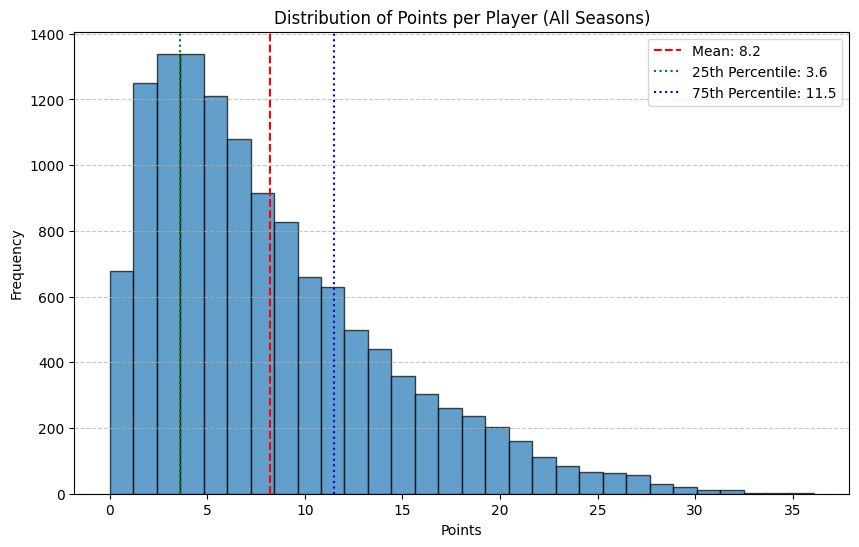

In [12]:
# Calculate statistics
mean_points = nba_players['pts'].mean()
max_points = nba_players['pts'].max()
points_25th = nba_players['pts'].quantile(0.25)
points_75th = nba_players['pts'].quantile(0.75)

# Display statistics
print(f"Mean Points per Player: {mean_points:.1f}")
print(f"Maximum Points: {max_points}")
print(f"Most players score between {points_25th} to {points_75th} points (25th to 75th percentile).")

# Plot: Distribution of Points per Player
plt.figure(figsize=(10, 6))
plt.hist(nba_players['pts'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_points, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_points:.1f}')
plt.axvline(points_25th, color='green', linestyle='dotted', linewidth=1.5, label=f'25th Percentile: {points_25th}')
plt.axvline(points_75th, color='blue', linestyle='dotted', linewidth=1.5, label=f'75th Percentile: {points_75th}')
plt.title('Distribution of Points per Player (All Seasons)')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()